In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import norm
from sklearn.linear_model import LassoCV, Lasso, LinearRegression, ElasticNet, Ridge
import patsy
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.simplefilter('ignore')
np.random.seed(1234)

# Problem 1

In [2]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)

data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1,0,0,0,1,0,0,0,0,1,7.0,0.49,0.343,0.2401,3600.0,11,8370.0,18
1,48.076923,3.872802,0,0,0,0,1,0,0,0,0,1,31.0,9.61,29.791,92.3521,3050.0,10,5070.0,9
2,11.057692,2.403126,0,0,1,0,0,0,0,0,0,1,18.0,3.24,5.832,10.4976,6260.0,19,770.0,4
3,13.942308,2.634928,1,0,0,0,0,1,0,0,0,1,25.0,6.25,15.625,39.0625,420.0,1,6990.0,12
4,28.846154,3.361977,1,0,0,0,1,0,0,0,0,1,22.0,4.84,10.648,23.4256,2015.0,6,9470.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,14.769231,2.692546,0,0,0,0,1,0,0,0,1,0,9.0,0.81,0.729,0.6561,4700.0,16,4970.0,9
5146,23.076923,3.138833,1,0,0,1,0,0,0,0,1,0,12.0,1.44,1.728,2.0736,4110.0,13,8680.0,20
5147,38.461538,3.649659,0,0,0,0,0,1,0,0,1,0,11.0,1.21,1.331,1.4641,1550.0,4,3680.0,6
5148,32.967033,3.495508,0,0,1,0,0,0,0,0,1,0,10.0,1.00,1.000,1.0000,2920.0,9,6570.0,11


**1a**

In [3]:
# OLS controlling for a small set of vars

OLS_small_controls = smf.ols("lwage ~ clg + sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2)",
              data)
OLS_small_controls_results = OLS_small_controls.fit(cov_type="HC1")

point_estimate = OLS_small_controls_results.params[OLS_small_controls.exog_names.index('clg')]
standard_error = OLS_small_controls_results.HC1_se[OLS_small_controls.exog_names.index('clg')]
CI = [point_estimate - 1.96*standard_error, point_estimate + 1.96*standard_error]

print("Small set of controls, OLS:")
print(f"Average Predictive Effect Point Estimate: {point_estimate}")
print(f"Average Predictive Effect 95% Confidence Interval: {CI}")

Small set of controls, OLS:
Average Predictive Effect Point Estimate: 0.1328553486006735
Average Predictive Effect 95% Confidence Interval: [0.10068811250358294, 0.16502258469776404]


In [4]:
# OLS using flexible set of controls

flex_controls = patsy.dmatrix("0 + (sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2", 
                              data, return_type='dataframe')
flex_controls = (flex_controls - flex_controls.mean(axis=0)) # demean all control covariates

X = flex_controls
X['clg'] = data['clg']

OLS_flex_controls = sm.OLS(data['lwage'], X)
OLS_flex_controls_results = OLS_flex_controls.fit(cov_type="HC1")

point_estimate = OLS_flex_controls_results.params[OLS_flex_controls.exog_names.index('clg')]
standard_error = OLS_flex_controls_results.HC1_se[OLS_flex_controls.exog_names.index('clg')]
CI = [point_estimate - 1.96*standard_error, point_estimate + 1.96*standard_error]

print("Flexible set of controls, OLS")
print(f"Average Predictive Effect Point Estimate: {point_estimate}")
print(f"Average Predictive Effect 95% Confidence Interval: {CI}")

Flexible set of controls, OLS
Average Predictive Effect Point Estimate: 3.8187933535387897
Average Predictive Effect 95% Confidence Interval: [3.7415285915537, 3.8960581155238794]


In [5]:
# Double Lasso using flexible set of controls

a = 0.05
const = 1.1

alpha = {}
res_y, res_D, epsilon = {}, {}, {}

c = 'clg'
y = data['clg']

#print(f"Double Lasso for target variable {c}")
D = X[c].values
W = X.drop([c], axis=1)

# Do the lasso penalty here
hatsigma = np.std(y)
lmbda_theory = 2*const*hatsigma*norm.ppf(1-a/(2*X.shape[1]))/np.sqrt(X.shape[0])
lasso_model = lambda: make_pipeline(StandardScaler(), Lasso(alpha=lmbda_theory))
res_y[c] = y - lasso_model().fit(W, y).predict(W)

# Do the lasso penalty here with Var(D)
hatsigma = np.std(D)
lmbda_theory = 2*const*hatsigma*norm.ppf(1-a/(2*X.shape[1]))/np.sqrt(X.shape[0])
lasso_model = lambda: make_pipeline(StandardScaler(), Lasso(alpha=lmbda_theory))
res_D[c] = D - lasso_model().fit(W, D).predict(W)

# Last Stage
final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
alpha[c] = [final.coef_[0]]



In [6]:
# Calculate standard errors for each parameter

n = X.shape[0]
SE = np.sqrt((np.mean(res_D[c]**2 * epsilon[c]**2)) / (np.mean(res_D[c]**2)**2 * n))
alpha[c] += [SE]

# put all in a dataframe
df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])

# Calculate and Pointwise p-value
summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['Std. Error'] = df['stderr']
summary['p-value'] = norm.sf(np.abs(df['point'] / df['stderr']), loc=0, scale=1) * 2
summary['ci_lower'] = df['point'] - 1.96 * df['stderr']
summary['ci_upper'] = df['point'] + 1.96 * df['stderr']

summary

,Estimate,Std. Error,p-value,ci_lower,ci_upper
clg,1.0,8.317847e-17,0.0,1.0,1.0


In [7]:
print("Flexible set of controls, Double Lasso")
print(f"Average Predictive Effect Point Estimate: {alpha[c][0]}")
print(f"Average Predictive Effect 95% Confidence Interval: {alpha[c][1]}")

Flexible set of controls, Double Lasso
Average Predictive Effect Point Estimate: 1.0000000000000047
Average Predictive Effect 95% Confidence Interval: 8.317846991244496e-17


**1b**

In [8]:
# exclude shs, hsg, scl, clg

y = np.log(data['wage']).values
Z = data.drop(['wage', 'lwage'], axis=1)
Z.columns

# Ultra flexible controls of all pair-wise interactions (around 1k variables); un-comment to run this
Zcontrols = patsy.dmatrix('0 + (C(occ2)+C(ind2)+mw+so+we+exp1+exp2+exp3+exp4)**2',
                           Z, return_type='dataframe')

Zcontrols = Zcontrols - Zcontrols.mean(axis=0)

Zhet = patsy.dmatrix('0 + (mw+so+we+exp1+exp2+exp3+exp4)',
                      Z, return_type='dataframe')
Zhet = Zhet - Zhet.mean(axis=0)

Zhet['clg'] = Z['clg']

Zinteractions = patsy.dmatrix('0 + clg + clg * (mw+so+we+exp1+exp2+exp3+exp4)',
                               Zhet, return_type='dataframe')
interaction_cols = [c for c in Zinteractions.columns if c.startswith('clg')]

X = pd.concat([Zinteractions, Zcontrols], axis=1)
X.shape

(5150, 792)

In [9]:
# OLS
# Using FWL theorem method because we are only interested in select coeffecient estimates

alpha = {}
res_y, res_D, epsilon = {}, {}, {}

for c in interaction_cols:
    #print(f"Double OLS for target variable {c}")
    D = X[c].values
    W = X.drop([c], axis=1)

    res_y[c] = y - LinearRegression(fit_intercept=False).fit(W, y).predict(W)

    res_D[c] = D - LinearRegression(fit_intercept=False).fit(W, D).predict(W)

    # Last Stage
    final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
    epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
    alpha[c] = [final.coef_[0]]


df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point'])

df

,point
clg,0.719271
clg:mw,-0.205294
clg:so,-0.395948
clg:we,-0.342730
clg:exp1,-0.679879
clg:exp2,4.626998
clg:exp3,-1.475477
clg:exp4,0.153977


In [10]:
# Lasso CV

reg = LassoCV(cv=5, random_state=0).fit(X, y)
coeffs = reg.coef_ 

alpha = {}

for c in interaction_cols:
    alpha[c] = coeffs[X.columns.get_loc(c)]

df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point'])

df

,point
clg,0.012055
clg:mw,0.000000
clg:so,0.000000
clg:we,-0.000000
clg:exp1,-0.000000
clg:exp2,-0.000000
clg:exp3,-0.000000
clg:exp4,-0.001047


In [14]:
# Lasso with theoretical penalty

a = 0.05
const = 1.1

alpha = {}
res_y, res_D, epsilon = {}, {}, {}


# Do the lasso penalty here
hatsigma = np.std(y)
lmbda_theory = 2*const*hatsigma*norm.ppf(1-a/(2*X.shape[1]))/np.sqrt(X.shape[0])
reg = Lasso(alpha=lmbda_theory).fit(X, y)

coeffs = reg.coef_ 

alpha = {}

for c in interaction_cols:
    alpha[c] = coeffs[X.columns.get_loc(c)]

df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point'])
df

,point
clg,0.000000
clg:mw,0.000000
clg:so,0.000000
clg:we,-0.000000
clg:exp1,0.000000
clg:exp2,-0.000000
clg:exp3,-0.000000
clg:exp4,-0.001219


In [18]:
# ElasticNet

a = 0.05
const = 1.1

alpha = {}
res_y, res_D, epsilon = {}, {}, {}


reg = ElasticNet(random_state=0).fit(X, y)

coeffs = reg.coef_ 

alpha = {}

for c in interaction_cols:
    alpha[c] = coeffs[X.columns.get_loc(c)]

df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point'])
df

,point
clg,0.00000
clg:mw,-0.00000
clg:so,0.00000
clg:we,-0.00000
clg:exp1,-0.00000
clg:exp2,-0.00000
clg:exp3,-0.00000
clg:exp4,-0.00005


In [19]:
# Ridge

a = 0.05
const = 1.1

alpha = {}
res_y, res_D, epsilon = {}, {}, {}


reg = Ridge(alpha=1.0).fit(X, y)

coeffs = reg.coef_ 

alpha = {}

for c in interaction_cols:
    alpha[c] = coeffs[X.columns.get_loc(c)]

df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point'])
df

,point
clg,0.128129
clg:mw,0.023981
clg:so,0.001858
clg:we,-0.057664
clg:exp1,0.051052
clg:exp2,-0.459691
clg:exp3,0.163931
clg:exp4,-0.019795


OLS results optimize MSE, so all coefficients take on some value. Lasso and ElasticNet results drive most coefficients down to 0 because non-zero coefficients are penalized. ElasticNet combines Lasso and Ridge penalties, but it seems the non-zero coefficient penalty from Lasso is dominating. Ridge has many small, non-zero coefficients because Ridge penalizes only large coefficients and favors small coefficients.

**1c**

In [20]:
a = 0.05
const = 1.1

alpha = {}
res_y, res_D, epsilon = {}, {}, {}
for c in interaction_cols:
    print(f"Double Lasso for target variable {c}")
    D = X[c].values
    W = X.drop([c], axis=1)

    # Do the lasso penalty here
    hatsigma = np.std(y)
    lmbda_theory = 2*const*hatsigma*norm.ppf(1-a/(2*X.shape[1]))/np.sqrt(X.shape[0])
    lasso_model = lambda: make_pipeline(StandardScaler(), Lasso(alpha=lmbda_theory))
    res_y[c] = y - lasso_model().fit(W, y).predict(W)

    # Do the lasso penalty here with Var(D)
    hatsigma = np.std(D)
    lmbda_theory = 2*const*hatsigma*norm.ppf(1-a/(2*X.shape[1]))/np.sqrt(X.shape[0])
    lasso_model = lambda: make_pipeline(StandardScaler(), Lasso(alpha=lmbda_theory))
    res_D[c] = D - lasso_model().fit(W, D).predict(W)

    # Last Stage
    final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
    epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
    alpha[c] = [final.coef_[0]]
    
# Calculate the covariance matrix of the estimated parameters
V = np.zeros((len(interaction_cols), len(interaction_cols)))
for it, c in enumerate(interaction_cols):
    Jc = np.mean(res_D[c]**2)
    for itp, cp in enumerate(interaction_cols):
        Jcp = np.mean(res_D[cp]**2)
        Sigma = np.mean(res_D[c] * epsilon[c] * epsilon[cp] * res_D[cp])
        V[it, itp] = Sigma / (Jc * Jcp)

# Calculate standard errors for each parameter
n = X.shape[0]
for it, c in enumerate(interaction_cols):
    alpha[c] += [np.sqrt(V[it, it] / n)]

# put all in a dataframe
df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])

# Calculate and Pointwise p-value
summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['Std. Error'] = df['stderr']
summary['p-value'] = norm.sf(np.abs(df['point'] / df['stderr']), loc=0, scale=1) * 2
summary['ci_lower'] = df['point'] - 1.96 * df['stderr']
summary['ci_upper'] = df['point'] + 1.96 * df['stderr']
summary

Double Lasso for target variable clg
Double Lasso for target variable clg:mw
Double Lasso for target variable clg:so
Double Lasso for target variable clg:we
Double Lasso for target variable clg:exp1
Double Lasso for target variable clg:exp2
Double Lasso for target variable clg:exp3
Double Lasso for target variable clg:exp4


,Estimate,Std. Error,p-value,ci_lower,ci_upper
clg,0.225472,0.016203,5.121876e-44,0.193714,0.257230
clg:mw,0.051348,0.041110,2.116574e-01,-0.029229,0.131924
clg:so,0.001493,0.039148,9.695847e-01,-0.075237,0.078222
clg:we,-0.094086,0.040576,2.040903e-02,-0.173616,-0.014556
clg:exp1,0.018003,0.004055,9.023456e-06,0.010054,0.025951
clg:exp2,0.089865,0.027698,1.176696e-03,0.035577,0.144152
clg:exp3,0.014556,0.008894,1.017414e-01,-0.002878,0.031989
clg:exp4,-0.005464,0.001712,1.411923e-03,-0.008818,-0.002109


Lasso CV has drives most coefficients to 0 due to its penalty, while Double Lasso does not. This is because Double Lasso uses OLS for its final step, while does not penalize non-zero coefficients and aims exclusively to minimize MSE. 

**1d**

In [22]:
# Diagonal of covariance matrix

np.diag(V)

array([1.35211534, 8.70385436, 7.89263063, 8.47914678, 0.08469434,
       3.95090403, 0.40742332, 0.01508689])

In [21]:
# Joint Intervals
Drootinv = np.diagflat(1/np.sqrt(np.diag(V)))
scaledCov = Drootinv @ V @ Drootinv
np.random.seed(123)
U = np.random.multivariate_normal(np.zeros(scaledCov.shape[0]), scaledCov, size=10000)
z = np.max(np.abs(U), axis=1)
c = np.percentile(z, 95)
summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['CI lower'] = df['point'] - c * df['stderr']
summary['CI upper'] = df['point'] + c * df['stderr']
summary

,Estimate,CI lower,CI upper
clg,0.225472,0.181928,0.269016
clg:mw,0.051348,-0.059131,0.161826
clg:so,0.001493,-0.103711,0.106697
clg:we,-0.094086,-0.203129,0.014957
clg:exp1,0.018003,0.007105,0.028901
clg:exp2,0.089865,0.015431,0.164298
clg:exp3,0.014556,-0.009347,0.038458
clg:exp4,-0.005464,-0.010063,-0.000864


The joint confidence intervals for each coefficent compared to the simple 95% confidence interval. This allows us to account for the fact that with multiple interactions of an independent variable of interest, we may get "false positives" where one of the coefficients of an interaction term looks significant by chance. 

# Problem 2

**2a**

In [2]:
def gen_data(n, d, p, delta, base):
    D = np.random.binomial(1, p, size=(n,))
    X = np.random.normal(0, 1, size=(n, d))
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    y1 = delta + base + X[:, 0] + np.random.normal(0, 1, size=(n,))
    y = y1 * D + y0 * (1 - D)
    return y, D, X

In [3]:
def twomeans(y, D):
    hat0 = np.mean(y[D==0]) # mean of outcome of un-treated
    hat1 = np.mean(y[D==1]) # mean of outcome of treated
    V0 = np.var(y[D==0]) / np.mean(1 - D) # asymptotic variance of the mean of outcome of untreated
    V1 = np.var(y[D==1]) / np.mean(D) # asymptotic variance of the mean of outcome of treated
    return hat0, hat1, V0, V1

In [43]:
cov_dict = {}

for ss in 50, 350, 750:
    
    CI_coverage = []
    
    n = ss # n samples
    delta = 1.0 # treatment effect
    base = .3 # baseline outcome
    d = 10 # number of covariates
    p = 0.2
    
    for i in range(0, 100):
        
        y, D, X = gen_data(n, d, p, delta, base) # generate RCT data
        hat0, hat1, V0, V1 = twomeans(y, D) # calculate estimation quantities
        
        hat = hat1 - hat0 # estimate of effect
        stderr = np.sqrt((V0 + V1) / n) # standard error of estimate of effect
        ci = [hat - 1.96 * stderr, hat + 1.96 * stderr] # 95% confidence interval for effect

        CI_coverage.append(delta >= ci[0] and delta <= ci[1])
        
    cov_dict[ss] = CI_coverage
        
print(f"CI coverage with n=50: {np.mean(cov_dict[50])}")
print(f"CI coverage with n=350: {np.mean(cov_dict[350])}")
print(f"CI coverage with n=750: {np.mean(cov_dict[750])}")

CI coverage with n=50: 0.92
CI coverage with n=350: 0.95
CI coverage with n=750: 0.94


In general, we were targeting this value to be ~0.95. A 95% confidence interval should cover the true estimate in approximately 95% of the samples drawn. 

In [44]:
all_coverages = []

for ss in range(1, 1000):
    
    CI_coverage = []
    
    n = ss # n samples
    delta = 1.0 # treatment effect
    base = .3 # baseline outcome
    d = 10 # number of covariates
    p = 0.2
    
    for i in range(0, 100):
        
        y, D, X = gen_data(n, d, p, delta, base) # generate RCT data
        hat0, hat1, V0, V1 = twomeans(y, D) # calculate estimation quantities
        
        hat = hat1 - hat0 # estimate of effect
        stderr = np.sqrt((V0 + V1) / n) # standard error of estimate of effect
        ci = [hat - 1.96 * stderr, hat + 1.96 * stderr] # 95% confidence interval for effect

        CI_coverage.append(delta >= ci[0] and delta <= ci[1])
        
    all_coverages.append(CI_coverage)
        
all_coverages = [np.mean(ci_cov) for ci_cov in all_coverages]

Text(0.5, 1.0, '95% CI Coverage over 100 Samples (p=0.2)')

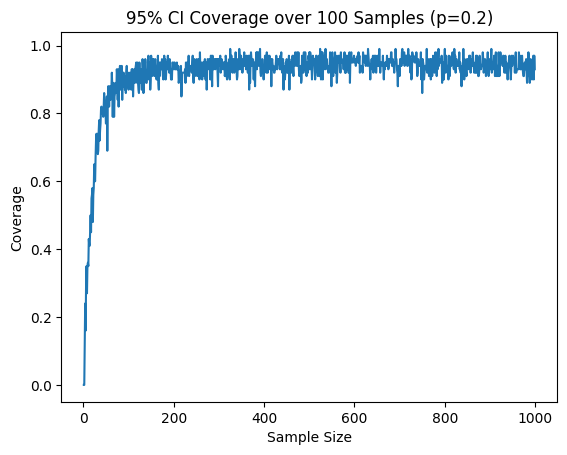

In [51]:
plt.plot(range(1, 1000), all_coverages)
plt.xlabel('Sample Size')
plt.ylabel('Coverage')
plt.title('95% CI Coverage over 100 Samples (p=0.2)')

The CI achieves the target coverage at about n=100. So, I would recommend the fellow student a sample size of at least 100 to trust their OLS confidence interval of the effect. 

In [52]:
# Repeating for p=0.1

all_coverages = []

for ss in range(1, 1000):
    
    CI_coverage = []
    
    n = ss # n samples
    delta = 1.0 # treatment effect
    base = .3 # baseline outcome
    d = 10 # number of covariates
    p = 0.1
    
    for i in range(0, 100):
        
        y, D, X = gen_data(n, d, p, delta, base) # generate RCT data
        hat0, hat1, V0, V1 = twomeans(y, D) # calculate estimation quantities
        
        hat = hat1 - hat0 # estimate of effect
        stderr = np.sqrt((V0 + V1) / n) # standard error of estimate of effect
        ci = [hat - 1.96 * stderr, hat + 1.96 * stderr] # 95% confidence interval for effect

        CI_coverage.append(delta >= ci[0] and delta <= ci[1])
        
    all_coverages.append(CI_coverage)
        
all_coverages = [np.mean(ci_cov) for ci_cov in all_coverages]

Text(0.5, 1.0, '95% CI Coverage over 100 Samples (p=0.1)')

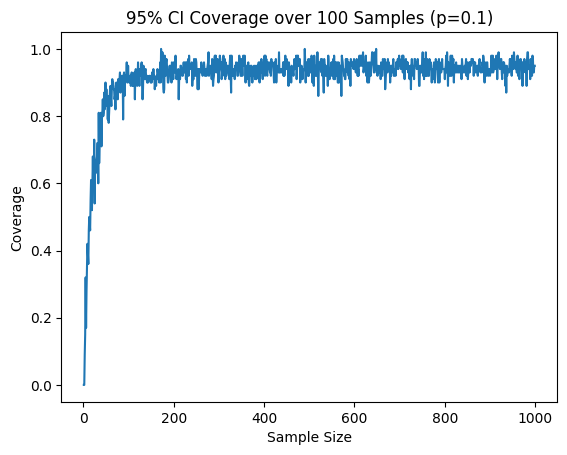

In [53]:
plt.plot(range(1, 1000), all_coverages)
plt.xlabel('Sample Size')
plt.ylabel('Coverage')
plt.title('95% CI Coverage over 100 Samples (p=0.1)')

Coverage for the 95% CI reaches about 0.95 when sample size is around 200 when p=0.1. It takes a larger sample size to achieve the target coverage when p=0.1 compared to p=0.2. When p is smaller, the variance of the mean of the treated group is larger, making our confidence intervals less stable. We need a higher sample size to approximate the asymptotic distribution of the estimate, and get more reliable CI coverage. 

**1b**

In [16]:
# OLS

all_coverages = []

n_list = np.arange(5, 501, 10)
n_list = np.insert(n_list, 0, 1)

for ss in n_list:
    
    CI_coverage = []
    
    n = ss # n samples
    delta = 1.0 # treatment effect
    base = .3 # baseline outcome
    d = 10 # number of covariates
    p = 0.2
    
    for i in range(0, 100):
        
        y, D, X = gen_data(n, d, p, delta, base) # generate RCT data
        
        X = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'])

        Xhet = patsy.dmatrix('0 + (x1+x2+x3+x4+x5+x6+x7+x8+x9+x10)',
                              X, return_type='dataframe')
        Xhet = Xhet - Xhet.mean(axis=0)
        Xhet['D'] = D
        
        Xinteractions = patsy.dmatrix('0 + D + D * (x1+x2+x3+x4+x5+x6+x7+x8+x9+x10)',
                                       Xhet, return_type='dataframe')

        ols = sm.OLS(y, Xinteractions)
        ols_result = ols.fit()
        ci = ols_result.get_robustcov_results(cov_type="HC1").conf_int()[0]

        CI_coverage.append(delta >= ci[0] and delta <= ci[1])
        
    all_coverages.append(CI_coverage)
        
all_coverages = [np.mean(ci_cov) for ci_cov in all_coverages]

Text(0.5, 1.0, '95% CI Coverage over 100 Samples (OLS)')

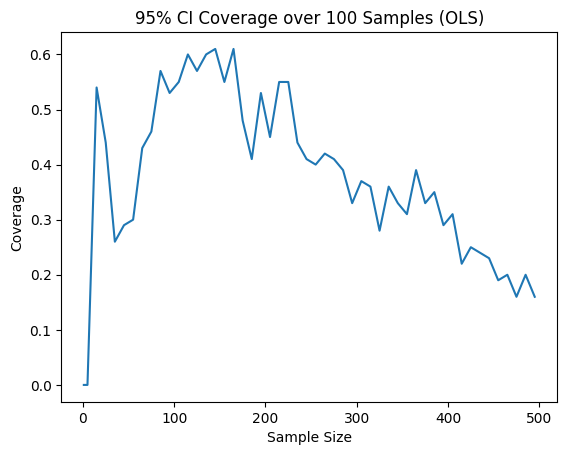

In [17]:
plt.plot(n_list, all_coverages)
plt.xlabel('Sample Size')
plt.ylabel('Coverage')
plt.title('95% CI Coverage over 100 Samples (OLS)')

OLS does not achieve good CI coverage. The coverage starts to decrease with a sample size of around 200. This is likely due to overfitting because we are not regularizing any of the parameters.

**1c**

In [92]:
# Double Lasso

all_coverages = []

for ss in n_list:
    
    CI_coverage = []
    
    n = ss # n samples
    delta = 1.0 # treatment effect
    base = .3 # baseline outcome
    d = 10 # number of covariates
    p = 0.2
    
    for i in range(0, 100):
        
        y, D, X = gen_data(n, d, p, delta, base) # generate RCT data
        
        X = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'])

        Xcontrols = patsy.dmatrix('0 + (x1+x2+x3+x4+x5+x6+x7+x8+x9+x10)**2',
                                   X, return_type='dataframe')
        Xcontrols = Xcontrols - Xcontrols.mean(axis=0)

        Xhet = patsy.dmatrix('0 + (x1+x2+x3+x4+x5+x6+x7+x8+x9+x10)',
                              X, return_type='dataframe')
        Xhet = Xhet - Xhet.mean(axis=0)

        Xhet['D'] = D
        Xinteractions = patsy.dmatrix('0 + D + D * (x1+x2+x3+x4+x5+x6+x7+x8+x9+x10)',
                                       Xhet, return_type='dataframe')

        interaction_cols = [c for c in Xinteractions.columns if c.startswith('D')]

        c = 'D'
        a = 0.05
        const = 1.1

        alpha = {}
        res_y, res_D, epsilon = {}, {}, {}

        D = Xinteractions[c].values
        W = Xinteractions.drop([c], axis=1)

        # Do the lasso penalty here
        hatsigma = np.std(y)
        lmbda_theory = 2*const*hatsigma*norm.ppf(1-a/(2*Xinteractions.shape[1]))/np.sqrt(Xinteractions.shape[0])
        lasso_model = lambda: make_pipeline(StandardScaler(), Lasso(alpha=lmbda_theory))
        res_y[c] = y - lasso_model().fit(W, y).predict(W)

        # Do the lasso penalty here with Var(D)
        hatsigma = np.std(D)
        lmbda_theory = 2*const*hatsigma*norm.ppf(1-a/(2*X.shape[1]))/np.sqrt(Xinteractions.shape[0])
        lasso_model = lambda: make_pipeline(StandardScaler(), Lasso(alpha=lmbda_theory))
        res_D[c] = D - lasso_model().fit(W, D).predict(W)

        # Last Stage
        final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
        epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
        alpha[c] = [final.coef_[0]]

        # Calculate standard errors for each parameter

        n = Xinteractions.shape[0]
        SE = np.sqrt((np.mean(res_D[c]**2 * epsilon[c]**2)) / (np.mean(res_D[c]**2)**2 * n))
        alpha[c] += [SE]

        ci = [alpha[c][0] - 1.96 * alpha[c][1], alpha[c][0] + 1.96 * alpha[c][1]]


        CI_coverage.append(delta >= ci[0] and delta <= ci[1])
        
    all_coverages.append(CI_coverage)
        
all_coverages = [np.mean(ci_cov) for ci_cov in all_coverages]

Text(0.5, 1.0, '95% CI Coverage over 100 Samples (Double Lasso)')

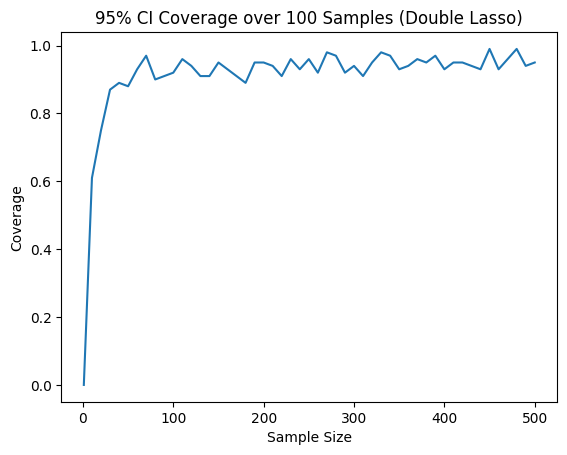

In [93]:
plt.plot(n_list, all_coverages)
plt.xlabel('Sample Size')
plt.ylabel('Coverage')
plt.title('95% CI Coverage over 100 Samples (Double Lasso)')

The 95% CI acheives decent coverage when the sample size reaches ~90. Double Lasso's coverage does not decrease because regularizating parameters prevents overfitting. 

# Problem 3

Citation:
Zachary S. Templeton, Nate C. Apathy, R. Tamara Konetzka, Meghan M. Skira, Rachel M. Werner,
The health effects of nursing home specialization in post-acute care,
Journal of Health Economics,
Volume 92,
2023,
102823,
ISSN 0167-6296,
https://doi.org/10.1016/j.jhealeco.2023.102823.

The above paper is attempting to determine the impact of specialization in post-acute care on patient health outcomes. Following some traumatic injury, many patients go to nursing homes to recover. Some of these nursing homes are specialized in in post acute care, while some are not. The benefits of specializing in taking care of post-injury patients is unclear. However, the causal effect of specialization is difficult to measure because there are many other factors (including unobservables) that may increase the liklihood of a patient going to a specialized treatment facility vs a regular treatment facility, and these factors may also effect their health outcomes. Examples include wealth (wealhtier people can afford more specialized care and can generally afford to eat healthier and exercise) and family support (supportive families can help patients get into specialized care and also take care of them better during recovery). 

In order to get around this issue, the above paper use proximity to nursing homes an instrumental variable. A patients proximity to a nursing home is independent to the unobservables increasing the propensity to select specialized or unspecialized nursing homes, but affects patient outcomes only through the nursing home selected. If we think wealth is the only confounding variable, we could calculate treatment effects via propensity scores for each wealth group and average those effects to get the ATE. 








In [18]:
"""
Causal graph:


 Post-acute care 
 specialization -----------> Recovery period
               ^                ^
               |              /
               |            /
               |          /
               |        /
               |      /
               |    /
              Wealth
"""

'\nCausal graph:\n\n\n Post-acute care \n specialization -----------> Recovery period\n               ^                ^\n               |              /\n               |            /\n               |          /\n               |        /\n               |      /\n               |    /\n              Wealth\n'